In [1]:
import warnings
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import OrderedDict
from plotting import line_plot_predictions, plot_cross_val_score
from baseline_models import Baseline_previous, Baseline_average, baseline_forecasts
from sarima_models import Sarima_predictions
from data_wrangling import Results_data, Data_preparation
plt.style.use('fivethirtyeight')

/home/rosina/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
project_name = 'project_e871'
freq = 'D'
season = 7
path = '../../capstone_data/Azimuth/clean/{}'.format(project_name)

In [3]:
# Get the project data and recreate the training dataset
dp = Data_preparation(path,freq)
df = dp.get_data()
y = dp.create_variable(agg='sum',feature='power_all')
# Get the results from the training and model comparisons
path_res = '../results/results_daily/output_'+project_name+'_daily'
res = Results_data(path_res).get_data()
results = res.df
res_sarima = results[results['model']=='sarima']
res_sarimax = results[results['model']=='sarimaX']

In [4]:
params_s = (res_sarima.iloc[0]['order'],res_sarima.iloc[0]['seasonal_order'])
params_sX = (res_sarimax.iloc[0]['order'],res_sarimax.iloc[0]['seasonal_order'])
params_sX_v = (res_sarimax.iloc[2]['order'],res_sarimax.iloc[2]['seasonal_order'])

In [5]:
plot_cross_val_score(results_train)

NameError: name 'results_train' is not defined

In [ ]:
# line plot for dependant variable
plt.figure(figsize=(16,6))
y_plot = y.iloc[:,0]/1000.
plt.plot(y.index, y_plot,label='Measured')
plt.fill_between(y.index, y.iloc[:,-1]*y_plot, alpha=0.4, label='Weekday')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Energy demand [kWh]')
title = 'Hourly energy demand for {}'.format(project_name)
plt.title(title)
plt.show()

## T-dependance

In [ ]:
# Plot of the temperature dependance
plt.figure(figsize=(8,8))
y_plot = y.iloc[:,0]/1000
plt.scatter(y.iloc[:,1], y_plot)
plt.xlabel('Temperature')
plt.ylabel('Energy demand [kWh]')
title = 'Temperature vs Energy Demand'.format(project_name)
plt.title(title)
plt.show()

## Training

In [6]:
y_train = y[:-2*season]
y_test = y[-2*season:]

In [7]:
# Define how big of a window you want to look at in the training data
window = 1*season

In [8]:
predictions = []

In [9]:
prediction_b1, prediction_b2 = baseline_forecasts(y_train,window,'D')


baseline - previous...
Baseline-previous test RMSE 112736.670936
baseline - averages....
Baseline-averages test RMSE 74578.3295164


baseline_models.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y['dayofweek'] = dateindex.dayofweek
baseline_models.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y.drop('dayofweek',axis=1, inplace=True)


In [10]:
predictions.append(['baseline_previous',prediction_b1])
predictions.append(['baseline_average',prediction_b2])

In [11]:
# get forecasts for sarima, sarimax and sarimax with variable beta coefficients
sp = Sarima_predictions(params_s, 0)
results_s = sp.rolling_predictions_sarima(y_train,len(y_train)-window, window)
sp = Sarima_predictions(params_sX,1)
results_sX = sp.rolling_predictions_sarima(y_train,len(y_train)-window, window)
sp = Sarima_predictions(params_sX_v,2)
results_sX_v = sp.rolling_predictions_sarima(y_train,len(y_train)-window, window)

In [12]:
prediction_s = results_s[0]
prediction_sX = results_sX[0]
prediction_sX_v = results_sX_v[0]

In [13]:
predictions.append(['sarima',prediction_s])
predictions.append(['sarimaX',prediction_sX])
predictions.append(['sarimaX_v',prediction_sX_v])

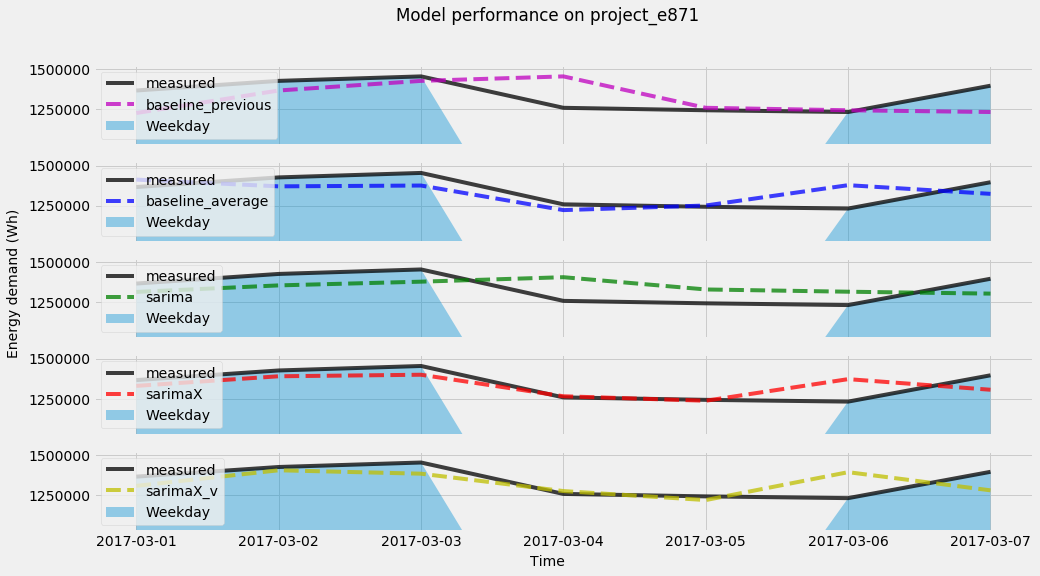

In [14]:
line_plot_predictions(project_name, predictions,y_train.iloc[-window:])

In [15]:
# Look at the sarima summary results
sp = Sarima_predictions(params_sX, 1)
model = sp.fit(y_train)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              power_all   No. Observations:                   39
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -473.842
Date:                Fri, 08 Sep 2017   AIC                            957.685
Time:                        11:25:27   BIC                            966.003
Sample:                    01-28-2017   HQIC                           960.669
                         - 03-07-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.247e+07     31.894   3.91e+05      0.000    1.25e+07    1.25e+07
T-1        -3.733e+04    117.345   -318.105      0.000   -3.76e+04   -3.71e+04
weekday     1.335e+05   3.71e+04      3.599      0.000    6.08e+04    2.06e+05
ma.L1          0.3627      0.178      2.041      0.041       0.014       0.711
sigma2      7.079e+09      0.017    4.2e+11      0.000    7.08e+09    7.08e+09
===================================================================================
Ljung-Box (Q):                       43.14   Jarque-Bera (JB):                 0.18
Prob(Q):                              0.19   Prob(JB):                         0.92
Heteroskedasticity (H):               1.22   Skew:                             0.16
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.31e+29. Standard errors may be unstable.
"""

## Training

In [24]:
forecasts = []
window = 2*season

In [25]:
forecast_b1, forecast_b2 = baseline_forecasts(y,window,'D')


baseline - previous...
Baseline-previous test RMSE 98299.7242756
baseline - averages....
Baseline-averages test RMSE 113095.606165


In [26]:
forecasts.append(['baseline_previous',forecast_b1])
forecasts.append(['baseline_average',forecast_b2])

In [27]:
sp = Sarima_predictions(params_s, 0)
results_s = sp.rolling_predictions_sarima(y,len(y)-window,window)
sp = Sarima_predictions(params_sX,1)
results_sX = sp.rolling_predictions_sarima(y,len(y)-window, window)
sp = Sarima_predictions(params_sX_v,2)
results_sX_v = sp.rolling_predictions_sarima(y,len(y)-window, window)

In [28]:
forecast_s = results_s[0]
forecast_sX = results_sX[0]
forecast_sX_v = results_sX_v[0]

In [29]:
forecasts.append(['sarima',forecast_s])
forecasts.append(['sarimaX_f',forecast_sX])
forecasts.append(['sarimaX_f',forecast_sX_v])

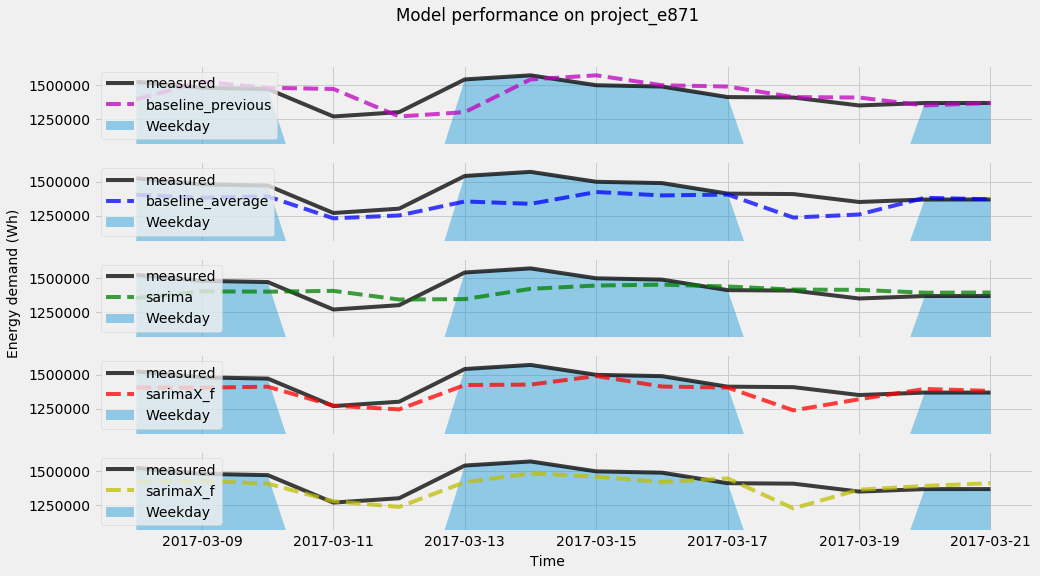

In [31]:
line_plot_predictions(project_name, forecasts,y_test)